In [1]:
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib as mpl
import scipy.spatial.distance as dist

In [45]:
attributes = ["X_barcode", "S_barcode", "X_reps", "S_reps", "S_reps_im", "pm_matrix", "induced_matching"]
types_list = ["float", "float", "int", "int", "int", "int", "int", "int"]
EXECUTABLE_PATH = f"..\\x64\\Debug\\IBloFunMatchCPP.exe" # this is my particular path
def get_IBloFunMatch_subset(Dist_S, Dist_X, idS, attributes, types_list, output_dir):
    # Buffer files to write subsets and classes for communicating with C++ program 
    f_ind_sampl = output_dir + "\\indices_sample.out"
    f_dist_X = output_dir + "\\dist_X.out"
    f_dist_S = output_dir + "\\dist_S.out"
    output_data = {}
    # Compute distance matrices and save
    np.savetxt(f_ind_sampl, idS, fmt="%d", delimiter=" ", newline="\n")
    np.savetxt(f_dist_X, Dist_X, fmt="%.14e", delimiter=" ", newline="\n")
    np.savetxt(f_dist_S, Dist_S, fmt="%.14e", delimiter=" ", newline="\n")
    # Call IBloFunMatch C++ program (only for dimension 1 PH)
    ! {EXECUTABLE_PATH + " " + f_dist_S + " " + f_dist_X + " " + f_ind_sampl + " -d 2"}
    # Save barcodes and representatives reading them from output files
    data_read = []
    for attribute_name, typename in zip(attributes, types_list):
        print(f"attribute:{attribute_name}, type:{typename}")
        print(output_dir + "\\" + attribute_name + ".out")
        with open(output_dir + "\\" + attribute_name + ".out") as file:
            for line in file:
                if(attribute_name == "induced_matching"):
                    data_read.append(int(line))
                else:
                    data_line = line.split(" ")
                    if (typename=="int"): # lines end with additional space
                        data_line=data_line[:-1]
                    data_read.append(list(np.array(data_line).astype(typename)))
                # end if else 
            # end reading file lines 
            if typename=="float":
                output_data[attribute_name] = np.array(data_read)
            else:
                output_data[attribute_name] = data_read.copy()
            # end if-else 
        # end opening file 
        data_read.clear()
    # end saving all attributes 
    # end for 
    return output_data
# def get_IBloFunMatch_output_range

def plot_matching(IBloFunMatch_o, attributes, types_list, output_dir, ax, fig):
    X_barcode = IBloFunMatch_o["X_barcode"]
    S_barcode = IBloFunMatch_o["S_barcode"]
    X_reps = IBloFunMatch_o["X_reps"]
    induced_matching = IBloFunMatch_o["induced_matching"]
    if len(ax)!=2:
        raise ValueError

    lw_S, lw_X = 100/len(S_barcode), 100/len(X_barcode)
    for idx, bar in enumerate(S_barcode):
        ax[0].plot([bar[0], bar[1]], [idx, idx], c="orange", linewidth=lw_S, zorder=1)
    for idx, bar in enumerate(X_barcode):
        ax[1].plot([bar[0], bar[1]], [idx, idx], c="aquamarine", linewidth=lw_X, zorder=1)

    for ax_it in ax:
        ax_it.set_frame_on(False)
        ax_it.set_yticks([])

    # Plot Partial Matching
    for idx, idx_match in enumerate(induced_matching):
        if idx_match==-1:
            continue
        S_bar = S_barcode[idx]
        X_bar = X_barcode[idx_match]
        if X_bar[1]<S_bar[0]:
            continue
        # print(f"{S_bar} <--> {X_bar}, len: {X_bar[1]-S_bar[0]:.3f}")
        # Highlight matched bar sections 
        ax[0].plot([S_bar[0], X_bar[1]], [idx, idx], c="navy", linewidth=lw_S, zorder=2, alpha=0.5)
        ax[1].plot([S_bar[0], X_bar[1]], [idx_match, idx_match], c="navy", linewidth=lw_X, zorder=2, alpha=0.5)
        # Plot matchings
        pt_S = [S_bar[1], idx]
        pt_X = [X_bar[0], idx_match]
        con = mpl.patches.ConnectionPatch(
            xyA=pt_S, coordsA=ax[0].transData, 
            xyB=pt_X, coordsB=ax[1].transData,
            arrowstyle="-", connectionstyle='arc',
            color="navy", linewidth=2, zorder=4, alpha=0.3 #, alpha=match_prevalence
        )
        fig.add_artist(con)
    # end for

In [3]:
rng = default_rng(2)
r = 10
radius = rng.uniform(r-0.4*r, r+0.4*r, 100)
angle = np.pi * rng.uniform(0, 2, 100)
r=8
C1 = np.vstack((np.sqrt(radius) * np.cos(angle), np.sqrt(radius) * np.sin(angle))).transpose()
radius = rng.uniform(r-0.4*r, r+0.4*r, 80)
angle = np.pi * rng.uniform(0, 2, 80)
C2 = np.vstack((np.sqrt(radius) * np.cos(angle), np.sqrt(radius) * np.sin(angle))).transpose()+[0,6.5]
Y=np.vstack((C1,C2))

In [4]:
subset_indices = rng.choice(range(len(Y)), replace=False, size=110)
center_pts_bool = np.sqrt(np.sum((Y-[0,3.5])**2, axis=1))<1.4
subset_indices = [idx for idx in subset_indices if not center_pts_bool[idx]]
X = Y[subset_indices]

In [5]:
%%capture
output_dir="output/"
Dist_X = dist.squareform(dist.pdist(X))
Dist_Y = dist.squareform(dist.pdist(Y))
IBloFunMatch_o = get_IBloFunMatch_subset(Dist_X, Dist_Y, subset_indices, attributes, types_list, output_dir)

In [6]:
IBloFunMatch_o["pm_matrix"]

[[6], [11], [14], [16], [17, 18], [18]]

In [7]:
plots_folder = "plots/controlled_unstability"
# ! mkdir -p plots/controlled_unstability

[0.60681  0.701574] <--> [0.60681 0.66493], len: 0.058
[0.863266 0.872277] <--> [0.750584 0.872277], len: 0.009
[0.974995 1.06034 ] <--> [0.974995 1.06034 ], len: 0.085
[1.01117 1.10724] <--> [0.899339 1.10724 ], len: 0.096
[2.2011  4.49447] <--> [1.33687 4.45887], len: 2.258
[3.23576 4.45887] <--> [1.75785 4.08136], len: 0.846


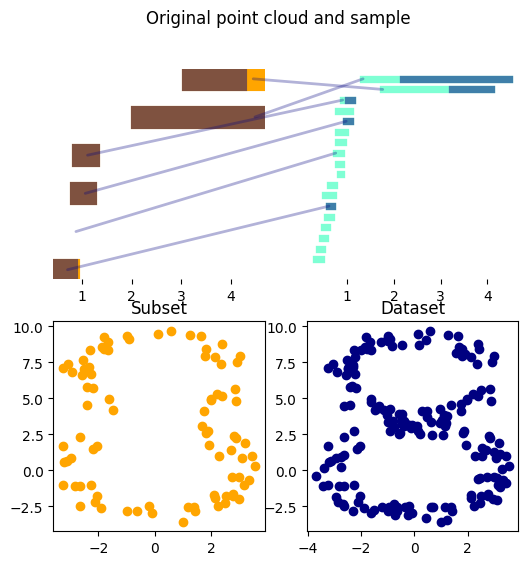

In [44]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
ax[1,0].scatter(X[:,0], X[:,1], c="orange")
ax[1,1].scatter(Y[:,0], Y[:,1], c="navy")
ax[1,0].set_title("Subset")
ax[1,1].set_title("Dataset")
plot_matching(IBloFunMatch_o, attributes, types_list, output_dir, ax[0], fig)
fig.suptitle("Original point cloud and sample")
plt.savefig(f"{plots_folder}/two_circles.png")

Plot cycle representatives corresponding to last two bars from Subset

In [9]:
def plot_cycle(edge_list, points, color, axis):
    copy_edge_list = edge_list.copy()
    while len(copy_edge_list)>0:
        edge_vtx = points[[copy_edge_list.pop(), copy_edge_list.pop()]]
        axis.plot(edge_vtx[:,0], edge_vtx[:,1], color=color, linewidth=5)
    # end plotting edges 

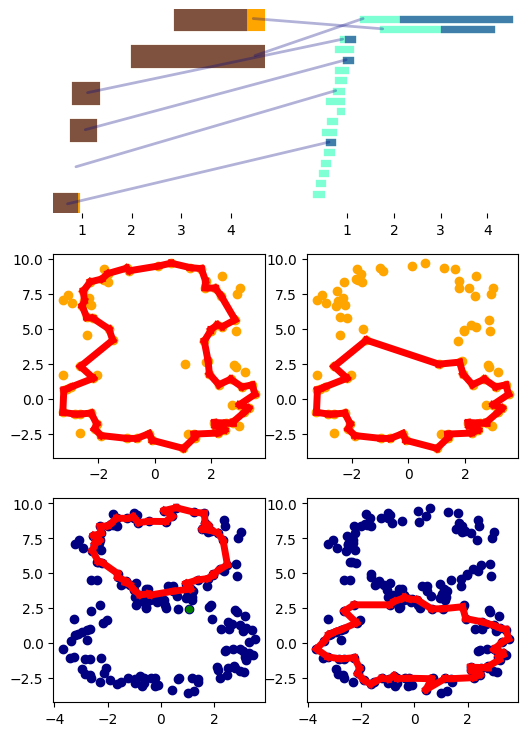

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(6,9))
plot_matching(IBloFunMatch_o, attributes, types_list, output_dir, ax[0], fig)
# Plot last two cycle bar representatives of subset 
ax[1,0].scatter(X[:,0], X[:,1], c="orange")
ax[1,1].scatter(X[:,0], X[:,1], c="orange")
ax[2,0].scatter([1.05],[2.45], c="green", s=20, zorder=6)
plot_cycle(IBloFunMatch_o["S_reps"][-2], Y, "red", ax[1,0])
plot_cycle(IBloFunMatch_o["S_reps"][-1], Y, "red", ax[1,1])
# Plot last two cycle bar representatives of dataset
ax[2,0].scatter(Y[:,0], Y[:,1], c="navy")
ax[2,1].scatter(Y[:,0], Y[:,1], c="navy")
plot_cycle(IBloFunMatch_o["X_reps"][-2], Y, "red", ax[2,0])
plot_cycle(IBloFunMatch_o["X_reps"][-1], Y, "red", ax[2,1])

In [11]:
IBloFunMatch_o["pm_matrix"]

[[6], [11], [14], [16], [17, 18], [18]]

In [12]:
np.sum(np.sum((Y-[1.1,2.5])**2, axis=1)<0.1)

1

In [13]:
assert np.sum(np.sum((Y-[1.1,2.4])**2, axis=1)<0.1)==1
# Take a "very well selected" point
pt_idx = (np.sum((Y-[1.1,2.4])**2, axis=1)<0.1).nonzero()[0][0]
pt_idx

11

In [14]:
Y_mod = Y.copy()
print(Y_mod[pt_idx])
Y_mod[pt_idx] = Y_mod[pt_idx] + (0,0)
print(Y_mod[pt_idx])
X = Y_mod[subset_indices]

[1.06874881 2.46135615]
[1.06874881 2.46135615]


In [15]:
%%capture
output_dir="output/"
Dist_X = dist.squareform(dist.pdist(X))
Dist_Y = dist.squareform(dist.pdist(Y_mod))
IBloFunMatch_o = get_IBloFunMatch_subset(Dist_X, Dist_Y, subset_indices, attributes, types_list, output_dir)

In [17]:
import itertools

In [47]:
pt_idx in subset_indices

True

In [46]:
%%capture
Y_mod = Y.copy()
for i,j in list(itertools.product(range(7), range(7))):
    h_shift = 0.2*(i-3)
    v_shift = 0.2*(j-3)
    Y_mod[pt_idx] = Y[pt_idx] + (h_shift, v_shift)
    X = Y_mod[subset_indices]
    # Compute block function 
    output_dir="output/"
    Dist_X = dist.squareform(dist.pdist(X))
    Dist_Y = dist.squareform(dist.pdist(Y_mod))
    IBloFunMatch_o = get_IBloFunMatch_subset(Dist_X, Dist_Y, subset_indices, attributes, types_list, output_dir)
    # Do plots
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
    ax[1,0].scatter(X[:,0], X[:,1], c="orange")
    ax[1,1].scatter(Y_mod[:,0], Y_mod[:,1], c="navy")
    # Plot Special point 
    point = Y_mod[[pt_idx]]
    ax[1,0].scatter(point[:,0], point[:,1], c="green", s=30)
    ax[1,1].scatter(point[:,0], point[:,1], c="green", s=30)
    ax[1,0].set_title("Subset")
    ax[1,1].set_title("Dataset")
    plot_matching(IBloFunMatch_o, attributes, types_list, output_dir, ax[0], fig)
    fig.suptitle(f"Shift: ({h_shift:.1f}, {v_shift:.1f})")
    plt.savefig(f"{plots_folder}/one_point_shift/two_circles_{i}_{j}.png")

Modify just ends of long bars in domain

In [23]:
Dist_Y = dist.squareform(dist.pdist(Y))

In [39]:
edge_first_end = np.where(np.abs(Dist_Y - IBloFunMatch_o["S_barcode"][-1][1])<0.0001)[0]
edge_first_end

array([29, 84], dtype=int64)

In [40]:
edge_second_end = np.where(np.abs(Dist_Y - IBloFunMatch_o["S_barcode"][-2][1])<0.0001)[0]
edge_second_end

array([158, 170], dtype=int64)

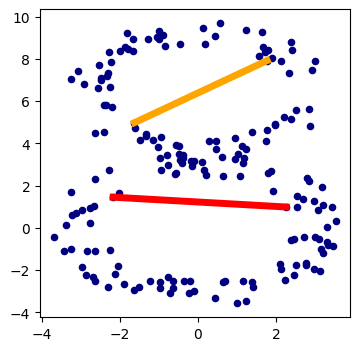

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax.scatter(Y[:,0], Y[:,1], c="navy", s=20)
first_edge = Y[edge_first_end]
second_edge = Y[edge_second_end]
ax.plot(first_edge[:,0], first_edge[:,1], c="red", linewidth=5)
ax.plot(second_edge[:,0], second_edge[:,1], c="orange", linewidth=5)
plt.savefig(f"{plots_folder}/points_long_edges.png")